In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import operator
from tensorflow import keras
import keras
import timeit
from tqdm import tqdm
from keras.callbacks import EarlyStopping
from sklearn import preprocessing
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from sklearn.linear_model import LogisticRegression

In [2]:
#set directory
os.chdir(r"C:\Users\Roswita Hede\Documents\IE7300\final project")

In [3]:
df=pd.read_csv("in-vehicle-coupon-recommendation.csv")
df.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


# Data Cleaning

In [4]:
# check missing value
df.isnull().sum()

destination                 0
passanger                   0
weather                     0
temperature                 0
time                        0
coupon                      0
expiration                  0
gender                      0
age                         0
maritalStatus               0
has_children                0
education                   0
occupation                  0
income                      0
car                     12576
Bar                       107
CoffeeHouse               217
CarryAway                 151
RestaurantLessThan20      130
Restaurant20To50          189
toCoupon_GEQ5min            0
toCoupon_GEQ15min           0
toCoupon_GEQ25min           0
direction_same              0
direction_opp               0
Y                           0
dtype: int64

In [5]:
# fill na with mode
df = df.drop(columns=['car'])
df['Bar'].fillna(df['Bar'].mode()[0], inplace=True)
df['CoffeeHouse'].fillna(df['CoffeeHouse'].mode()[0], inplace=True)
df['CarryAway'].fillna(df['CarryAway'].mode()[0], inplace=True)
df['RestaurantLessThan20'].fillna(df['RestaurantLessThan20'].mode()[0], inplace=True)
df['Restaurant20To50'].fillna(df['Restaurant20To50'].mode()[0], inplace=True)

In [6]:
df.isnull().sum()

destination             0
passanger               0
weather                 0
temperature             0
time                    0
coupon                  0
expiration              0
gender                  0
age                     0
maritalStatus           0
has_children            0
education               0
occupation              0
income                  0
Bar                     0
CoffeeHouse             0
CarryAway               0
RestaurantLessThan20    0
Restaurant20To50        0
toCoupon_GEQ5min        0
toCoupon_GEQ15min       0
toCoupon_GEQ25min       0
direction_same          0
direction_opp           0
Y                       0
dtype: int64

In [7]:
#drop dupilicate data
df = df.drop_duplicates()

# Explanatory Data Analysis

Accepted coupon: 7157 56.76 %
Rejected coupon: 5453 43.24 %


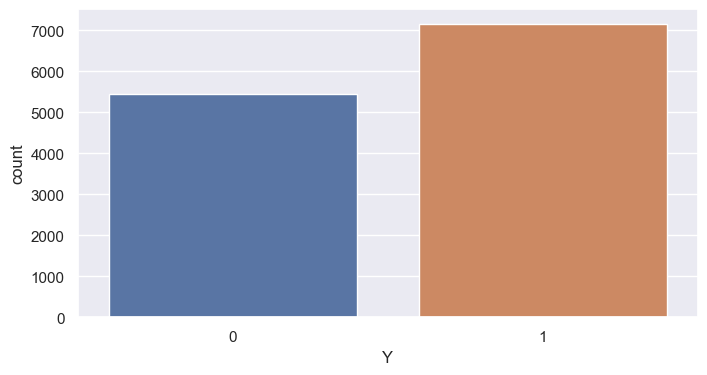

In [8]:
# Distribution of classes
sns.set(rc={"figure.figsize":(8,4)})
sns.countplot(x='Y', data=df)
Y_counts = df.groupby('Y').Y.count()
print('Accepted coupon:',Y_counts[1],round(Y_counts[1]/df.shape[0]*100,2),'%')
print('Rejected coupon:',Y_counts[0],round(Y_counts[0]/df.shape[0]*100,2),'%')

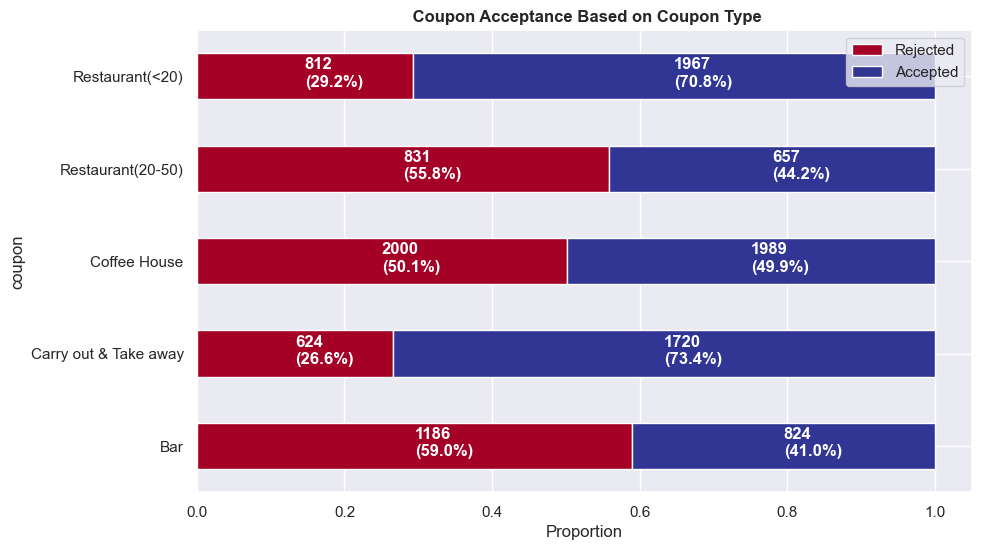

In [9]:
# univariate (coupon & Y)
df_coupon = df[['coupon','Y']]
cross_tab = pd.crosstab(index=df_coupon['coupon'],
                        columns=df_coupon['Y'])
cross_tab_prop = pd.crosstab(index=df_coupon['coupon'],
                             columns=df_coupon['Y'],
                             normalize="index")
cross_tab_prop.plot(kind='barh', 
                        stacked=True, 
                        colormap='RdYlBu', 
                        figsize=(10, 6))

plt.legend(loc="lower left", ncol=2)
plt.legend(labels=['Rejected','Accepted'])
plt.ylabel("coupon")
plt.xlabel("Proportion")
plt.title(' Coupon Acceptance Based on Coupon Type', weight='bold')


for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, count, y_loc) in zip(cross_tab_prop.loc[x],
                                          cross_tab.loc[x],
                                          cross_tab_prop.loc[x].cumsum()):
                
        plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{count}\n({np.round(proportion * 100, 1)}%)', 
                 color="white",
                 fontsize=12,
                 fontweight="bold")

plt.show()

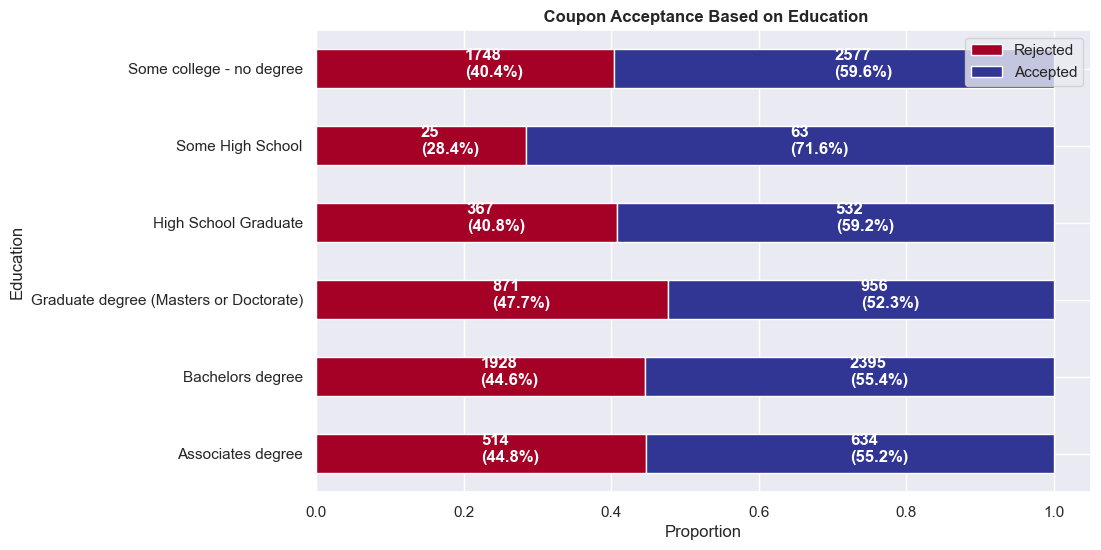

In [10]:
# Univeriate(education & Y)
df_edu = df[['education','Y']]
cross_tab = pd.crosstab(index=df_edu['education'],
                        columns=df_edu['Y'])
cross_tab_prop = pd.crosstab(index=df_edu['education'],
                             columns=df_edu['Y'],
                             normalize="index")
cross_tab_prop.plot(kind='barh', 
                        stacked=True, 
                        colormap='RdYlBu', 
                        figsize=(10, 6))

plt.legend(loc="lower left", ncol=2)
plt.legend(labels=['Rejected','Accepted'])
plt.ylabel("Education")
plt.xlabel("Proportion")
plt.title(' Coupon Acceptance Based on Education',weight='bold' )


for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, count, y_loc) in zip(cross_tab_prop.loc[x],
                                          cross_tab.loc[x],
                                          cross_tab_prop.loc[x].cumsum()):
                
        plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{count}\n({np.round(proportion * 100, 1)}%)', 
                 color="white",
                 fontsize=12,
                 fontweight="bold")

plt.show()

In [11]:
def df_group(col):
    dfg = df.groupby([col, 'Y']).agg({'toCoupon_GEQ5min':'count'}).reset_index()
    dfg_sum = df.groupby(col).agg({'toCoupon_GEQ5min':'count'})
    dfg = dfg.merge(dfg_sum, on = col)
    dfg.rename(columns={'toCoupon_GEQ5min_x':'customers', 'toCoupon_GEQ5min_y':'total_customer'}, inplace=True)
    dfg['percentage'] = round((dfg['customers']/dfg['total_customer']) * 100, 2)
    return dfg

def barplot(col):
    df1 = df_group(col)
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16,8))
    sns.barplot(x = col, y= 'customers', hue = 'Y', data = df1, ax = ax[0])
    ax[0].set_ylabel('Total Customer')
    show_val_int(ax[0])
    sns.barplot(x = col, y= 'percentage', hue = 'Y', data = df1, ax = ax[1])
    show_val_percent(ax[1])
    
def continousplot(col):
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16,8))
    sns.boxplot(x = 'Y', y = col, data = df, ax = ax[0])
    sns.histplot(x = col, hue = 'Y', data = df, ax = ax[1])

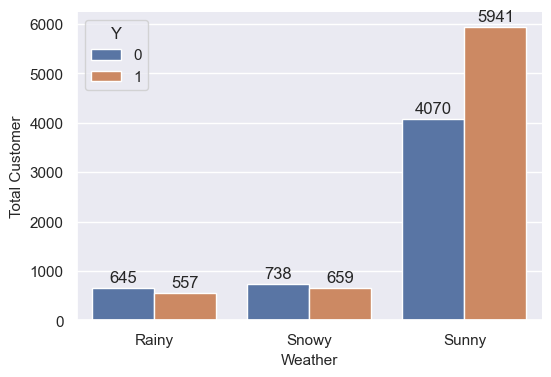

In [12]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(x='weather', y='customers', data=df_group('weather'), hue='Y')
plt.xlabel('Weather', fontsize=11)
plt.ylabel('Total Customer', fontsize=11)
plt.bar_label(ax.containers[0], padding=2)
plt.bar_label(ax.containers[1], padding=2)


sns.despine()

plt.show()

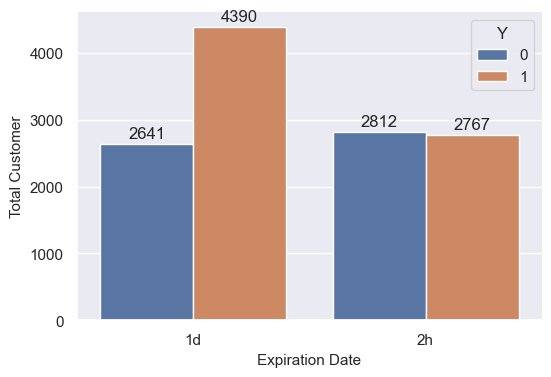

In [13]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(x='expiration', y='customers', data=df_group('expiration'), hue='Y')
plt.xlabel('Expiration Date', fontsize=11)
plt.ylabel('Total Customer', fontsize=11)
plt.bar_label(ax.containers[0], padding=2)
plt.bar_label(ax.containers[1], padding=2)


sns.despine()

plt.show()

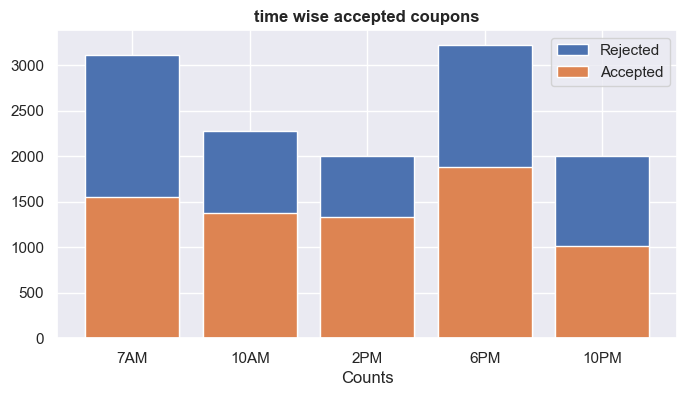

In [14]:
def univariate_analysis(column_name):
  df_EDA = pd.DataFrame(sorted(list(df[column_name].unique())),columns=[column_name])
  df_EDA['Total_Count'] = list(df.groupby(column_name).Y.count())
  df_EDA['Accepted'] = list(df[df.Y==1].groupby(column_name).Y.count())
  df_EDA['Rejected'] = list(df[df.Y==0].groupby(column_name).Y.count())
  df_EDA['%Accepted'] = round(df_EDA['Accepted']/df_EDA['Total_Count']*100,3)
  df_EDA['%Rejected'] = round(df_EDA['Rejected']/df_EDA['Total_Count']*100,3)
  df_EDA = df_EDA.sort_values(by='Total_Count')

  # Set the order of the bars
  order = ['7AM', '10AM', '2PM', '6PM', '10PM']
  df_EDA = df_EDA.set_index('time')
  df_EDA = df_EDA.reindex(order)
  df_EDA = df_EDA.reset_index()

  fig,ax = plt.subplots(figsize =(8, 4))
  plt.bar(df_EDA[column_name],df_EDA['Total_Count'])
  plt.bar(df_EDA[column_name],df_EDA['Accepted'])
  plt.legend(labels=['Rejected','Accepted'])
  plt.xlabel('Counts')
  plt.title(column_name+' wise accepted coupons',weight='bold')

  plt.show()

univariate_analysis('time')


In [15]:
df_6pm = df[df['time'] == '6PM'].groupby(['destination', 'Y']).agg({'toCoupon_GEQ5min':'count'}).reset_index()
df_6pm_sum = df_6pm.groupby('destination').agg({'toCoupon_GEQ5min':'sum'})
df_6pm = df_6pm.merge(df_6pm_sum, on = 'destination')
df_6pm.rename(columns={'toCoupon_GEQ5min_x':'customers', 'toCoupon_GEQ5min_y':'total_customer'}, inplace=True)
df_6pm['percentage'] = round((df_6pm['customers']/df_6pm['total_customer']) * 100, 2)
df_6pm

,destination,Y,customers,total_customer,percentage
0,Home,0,967,2118,45.66
1,Home,1,1151,2118,54.34
2,No Urgent Place,0,372,1102,33.76
3,No Urgent Place,1,730,1102,66.24


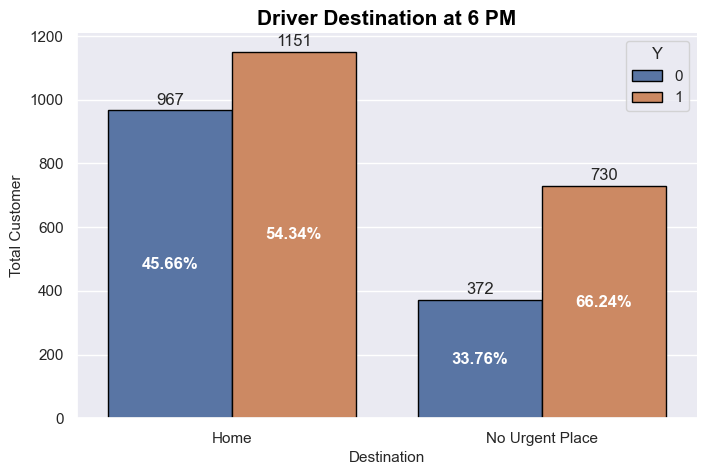

In [16]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.title("Driver Destination at 6 PM", fontsize=15, color='black', weight='bold')
sns.barplot(x='destination', y='customers', data=df_6pm, hue='Y', edgecolor='black')

plt.xlabel('Destination', fontsize=11)
plt.ylabel('Total Customer', fontsize=11)
plt.bar_label(ax.containers[0], padding=2)
plt.bar_label(ax.containers[1], padding=2)

plt.bar_label(ax.containers[0], ['45.66%', '33.76%'], label_type='center', color='white', weight='bold')
plt.bar_label(ax.containers[1], ['54.34%','66.24%'], label_type='center', color='white', weight='bold')

sns.despine()

plt.show()

In [17]:
df_7am = df[df['time'] == '7AM'].groupby(['destination', 'Y']).agg({'toCoupon_GEQ5min':'count'}).reset_index()
df_7am_sum = df_7am.groupby('destination').agg({'toCoupon_GEQ5min':'sum'})
df_7am = df_7am.merge(df_7am_sum, on = 'destination')
df_7am.rename(columns={'toCoupon_GEQ5min_x':'customers', 'toCoupon_GEQ5min_y':'total_customer'}, inplace=True)
df_7am['percentage'] = round((df_7am['customers']/df_7am['total_customer']) * 100, 2)
df_7am

,destination,Y,customers,total_customer,percentage
0,Work,0,1561,3114,50.13
1,Work,1,1553,3114,49.87


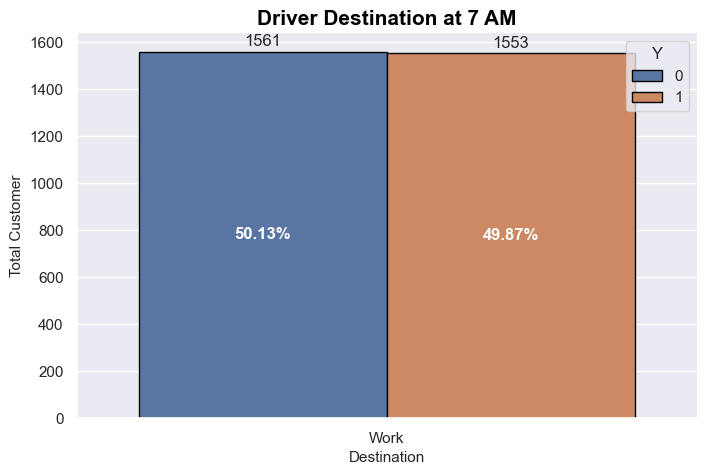

In [18]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.title("Driver Destination at 7 AM", fontsize=15, color='black', weight='bold')
sns.barplot(x='destination', y='customers', data=df_7am, hue='Y', edgecolor='black')

plt.xlabel('Destination', fontsize=11)
plt.ylabel('Total Customer', fontsize=11)
plt.bar_label(ax.containers[0], padding=2)
plt.bar_label(ax.containers[1], padding=2)

plt.bar_label(ax.containers[0], ['50.13%'], label_type='center', color='white', weight='bold')
plt.bar_label(ax.containers[1], ['49.87%'], label_type='center', color='white', weight='bold')

sns.despine()

plt.show()

In [19]:
df_10am = df[df['time'] == '10AM'].groupby(['destination', 'Y']).agg({'toCoupon_GEQ5min':'count'}).reset_index()
df_10am_sum = df_10am.groupby('destination').agg({'toCoupon_GEQ5min':'sum'})
df_10am = df_10am.merge(df_10am_sum, on = 'destination')
df_10am.rename(columns={'toCoupon_GEQ5min_x':'customers', 'toCoupon_GEQ5min_y':'total_customer'}, inplace=True)
df_10am['percentage'] = round((df_10am['customers']/df_10am['total_customer']) * 100, 2)
df_10am

,destination,Y,customers,total_customer,percentage
0,No Urgent Place,0,891,2271,39.23
1,No Urgent Place,1,1380,2271,60.77


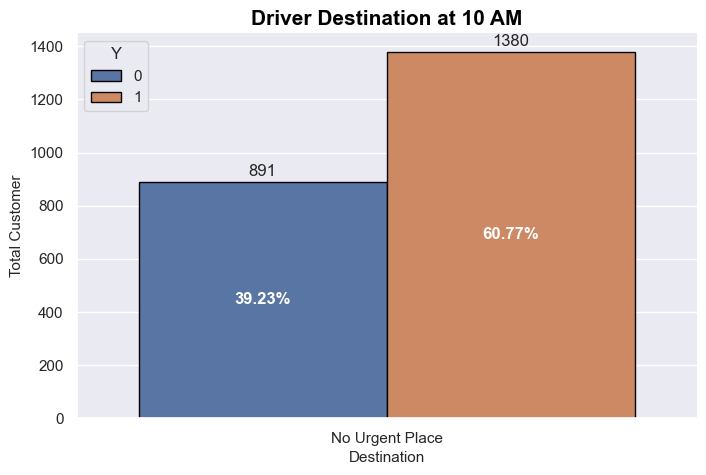

In [20]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.title("Driver Destination at 10 AM", fontsize=15, color='black', weight='bold')
sns.barplot(x='destination', y='customers', data=df_10am, hue='Y', edgecolor='black')

plt.xlabel('Destination', fontsize=11)
plt.ylabel('Total Customer', fontsize=11)
plt.bar_label(ax.containers[0], padding=2)
plt.bar_label(ax.containers[1], padding=2)

plt.bar_label(ax.containers[0], ['39.23%'], label_type='center', color='white', weight='bold')
plt.bar_label(ax.containers[1], ['60.77%'], label_type='center', color='white', weight='bold')

sns.despine()

plt.show()

In [21]:
df_2pm = df[df['time'] == '2PM'].groupby(['destination', 'Y']).agg({'toCoupon_GEQ5min':'count'}).reset_index()
df_2pm_sum = df_2pm.groupby('destination').agg({'toCoupon_GEQ5min':'sum'})
df_2pm = df_2pm.merge(df_2pm_sum, on = 'destination')
df_2pm.rename(columns={'toCoupon_GEQ5min_x':'customers', 'toCoupon_GEQ5min_y':'total_customer'}, inplace=True)
df_2pm['percentage'] = round((df_2pm['customers']/df_2pm['total_customer']) * 100, 2)
df_2pm

,destination,Y,customers,total_customer,percentage
0,No Urgent Place,0,679,2006,33.85
1,No Urgent Place,1,1327,2006,66.15


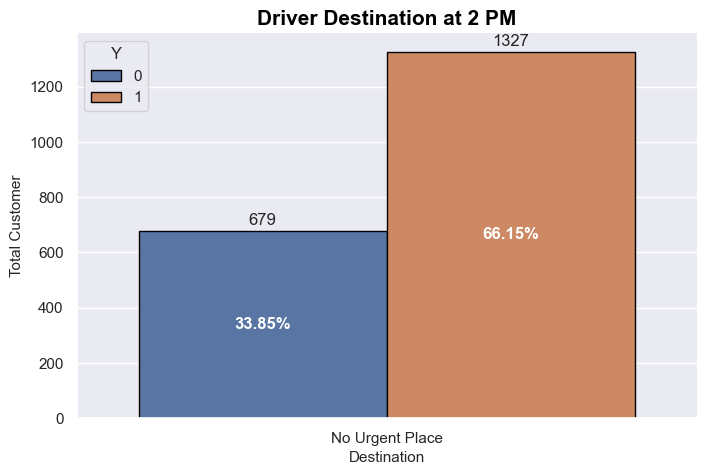

In [22]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.title("Driver Destination at 2 PM", fontsize=15, color='black', weight='bold')
sns.barplot(x='destination', y='customers', data=df_2pm, hue='Y', edgecolor='black')

plt.xlabel('Destination', fontsize=11)
plt.ylabel('Total Customer', fontsize=11)
plt.bar_label(ax.containers[0], padding=2)
plt.bar_label(ax.containers[1], padding=2)

plt.bar_label(ax.containers[0], ['33.85%'], label_type='center', color='white', weight='bold')
plt.bar_label(ax.containers[1], ['66.15%'], label_type='center', color='white', weight='bold')

sns.despine()

plt.show()

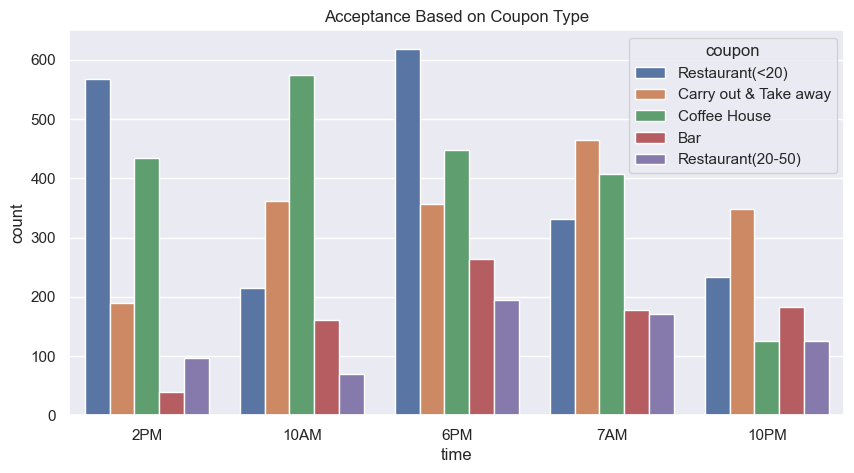

In [23]:
df_time_coupon = df[["time","coupon","Y"]]
df_acce = df_time_coupon.loc[df_time_coupon['Y'] == 1]
sns.set(rc={"figure.figsize":(10,5)})
sns.countplot(data=df_acce, x='time', hue='coupon').set(title='Acceptance Based on Coupon Type')
plt.show()

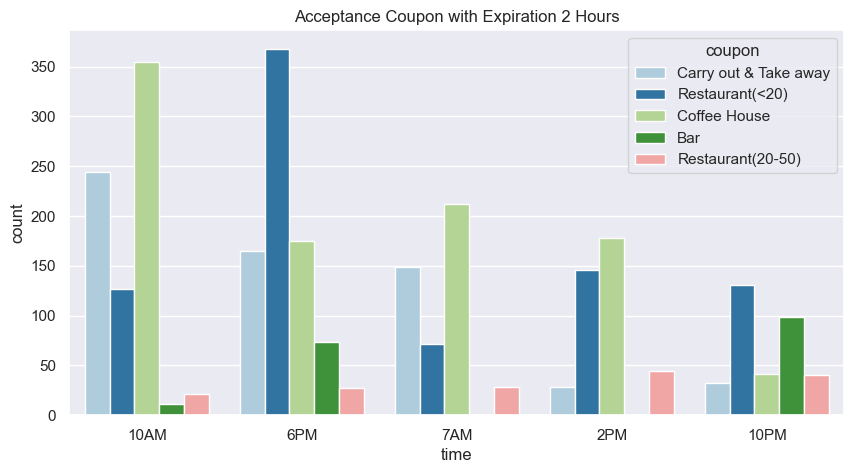

In [24]:
# Filter the DataFrame based on the 'expiration' column
df_time_coupon = df[df['expiration'] == '2h']

# Further filter the data to select only rows where 'Y' is equal to 1
df_acce = df_time_coupon[df_time_coupon['Y'] == 1]



# Set the figure size for the count plot
sns.set(rc={"figure.figsize": (10, 5)})

# Create a count plot
sns.countplot(data=df_acce, x='time', hue='coupon',palette="Paired").set(title='Acceptance Coupon with Expiration 2 Hours')

# Show the plot
plt.show()

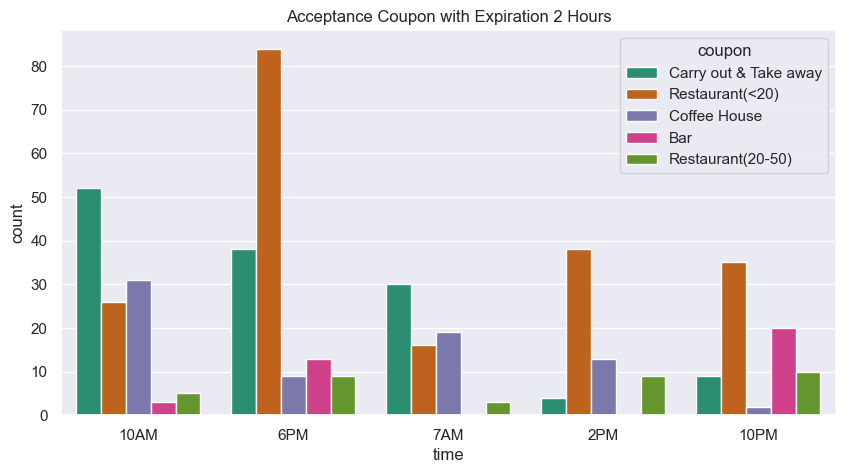

In [25]:
# Filter the DataFrame based on the specified conditions
df_filtered = df[(df['expiration'] == '2h') & (df['Y'] == 1) & (df['CoffeeHouse'] == 'never')]

# Set the figure size for the count plot
sns.set(rc={"figure.figsize": (10, 5)})

# Create a count plot
sns.countplot(data=df_filtered, x='time', hue='coupon',palette="Dark2").set(title='Acceptance Coupon with Expiration 2 Hours')

# Show the plot
plt.show()

# Feature Transformation

In [26]:
# combine "toCoupon_GEQ5min","toCoupon_GEQ15min" and "toCoupon_GEQ25min" into one column
def custom_where(ele):
  x,y,z = list(map(str,ele))
  if x == '1':
    if y == '1':
      if z == '1':
        return 'within 25mins'
      else:
        return 'within 15mins'
    else: return 'within 5mins'

In [27]:
df['driving_distance'] = df[['toCoupon_GEQ5min','toCoupon_GEQ15min','toCoupon_GEQ25min']].apply(custom_where,axis=1,raw=True)
df.drop(['toCoupon_GEQ5min','toCoupon_GEQ15min','toCoupon_GEQ25min'],axis=1,inplace=True)

In [28]:
#categorize it to be more simple
age_list = []
for i in df['age']:
    if i == 'below21':
        age = '<21'
    elif i == '21' or i == '26':
        age = '21-30'
    elif i == '31' or i == '36':
        age = '31-40'
    elif i == '41' or i == '46':
        age = '41-50'
    else:
        age = '>50'
    age_list.append(age)
df['age'] = age_list

In [29]:
df['age'].unique()

array(['21-30', '41-50', '31-40', '>50', '<21'], dtype=object)

In [30]:
#categorize it to be more simple
occupation_list = []
for i in df['occupation']:
    if i == 'Installation Maintenance & Repair' or i == 'Transportation & Material Moving' or i == 'Food Preparation & Serving Related' or i == 'Building & Grounds Cleaning & Maintenance':
        occupation = 'Crafts'
    elif i == 'Architecture & Engineering' or i == 'Education&Training&Library' or i == 'Healthcare Practitioners & Technical' or i == 'Management' or i == 'Arts Design Entertainment Sports & Media' or i == 'Computer & Mathematical' or i == 'Legal' or i == 'Business & Financial':
        occupation = 'Professionals'
    elif i == 'Retired':
        occupation = 'Retired'
    elif i == 'Sales & Related' or i == 'Personal Care & Service' or i == 'Protective Service':
        occupation = 'Service and sales'
    elif i == 'Student':
        occupation = 'Student'
    elif i == 'Healthcare Support' or i == 'Life Physical Social Science' or i == 'Community & Social Services' or i == 'Construction & Extraction':
        occupation = 'Technicians'
    elif i == 'Unemployed':
        occupation = 'Unemployed'
    else:
        occupation = 'Others'
    occupation_list.append(occupation)
df['occupation'] = occupation_list

In [31]:
df['occupation'].unique()

array(['Unemployed', 'Professionals', 'Student', 'Technicians',
       'Service and sales', 'Others', 'Retired', 'Crafts'], dtype=object)

In [32]:
has_children_list = []
for i in df['has_children']:
    if i == 1:
        has_children = 'Yes'
    else:
      has_children = 'No'
    has_children_list.append(has_children)
df['has_children'] = has_children_list

In [33]:
df['has_children'].unique()

array(['Yes', 'No'], dtype=object)

In [34]:
temperature_list = []
for i in df['temperature']:
    if i == 30:
      temperature = 'Low'
    elif i==55:
      temperature= 'Medium'
    else:
      temperature = 'High'
    temperature_list.append(temperature)
df['temperature'] = temperature_list

In [35]:
direction_same_list = []
for i in df['direction_same']:
    if i == 1:
      direction_same = 'Yes'
    else:
      direction_same = 'No'
    direction_same_list.append(direction_same)
df['direction_same'] = direction_same_list

In [36]:
Y_list = []
for i in df['Y']:
    if i == 1:
      Y = 'Accept'
    else:
      Y = 'Reject'
    Y_list.append(Y)
df['Y'] = Y_list

In [37]:
df['Y'].unique()

array(['Accept', 'Reject'], dtype=object)

# Data Encoding

In [38]:
df_enco = df.copy()
label_encoder = preprocessing.LabelEncoder()
df_enco['passanger']= label_encoder.fit_transform(df_enco['passanger'])
df_enco['weather']= label_encoder.fit_transform(df_enco['weather'])
df_enco['time']= label_encoder.fit_transform(df_enco['time'])
df_enco['coupon']= label_encoder.fit_transform(df_enco['coupon'])
df_enco['expiration']= label_encoder.fit_transform(df_enco['expiration'])
df_enco['gender']= label_encoder.fit_transform(df_enco['gender'])
df_enco['age']= label_encoder.fit_transform(df_enco['age'])
df_enco['maritalStatus']= label_encoder.fit_transform(df_enco['maritalStatus'])
df_enco['education']= label_encoder.fit_transform(df_enco['education'])
df_enco['occupation']= label_encoder.fit_transform(df_enco['occupation'])
df_enco['income']= label_encoder.fit_transform(df_enco['income'])
df_enco['Bar']= label_encoder.fit_transform(df_enco['Bar'])
df_enco['CoffeeHouse']= label_encoder.fit_transform(df_enco['CoffeeHouse'])
df_enco['CarryAway']= label_encoder.fit_transform(df_enco['CarryAway'])
df_enco['RestaurantLessThan20']= label_encoder.fit_transform(df_enco['RestaurantLessThan20'])
df_enco['Restaurant20To50']= label_encoder.fit_transform(df_enco['Restaurant20To50'])
df_enco['driving_distance']= label_encoder.fit_transform(df_enco['driving_distance'])
df_enco['temperature']= label_encoder.fit_transform(df_enco['temperature'])
df_enco['has_children']= label_encoder.fit_transform(df_enco['has_children'])
df_enco['direction_same']= label_encoder.fit_transform(df_enco['direction_same'])
df_enco['destination']= label_encoder.fit_transform(df_enco['destination'])
df_enco['Y']= label_encoder.fit_transform(df_enco['Y'])

(array([8.51872185e-02, 4.49153726e+01, 2.80958257e+01, 4.15522212e+01,
       2.79059310e+01, 1.09915816e+02, 1.16527040e+02, 1.23766588e+01,
       4.06618193e+01, 3.27933140e+00, 1.49879269e+01, 3.22563112e+01,
       2.95063861e-01, 1.39837347e+01, 6.71770851e+01, 2.97944201e+02,
       3.40513002e+01, 2.24323428e+00, 3.98201425e+01, 2.20550210e+00,
       6.06000274e-01, 2.85147148e+01]), array([7.70387172e-01, 2.05736369e-11, 1.15454615e-07, 1.14764019e-10,
       1.27358779e-07, 1.02241869e-25, 3.64377189e-27, 4.34734409e-04,
       1.80989197e-10, 7.01575045e-02, 1.08201215e-04, 1.35117495e-08,
       5.86993614e-01, 1.84398961e-04, 2.48182102e-16, 9.23986896e-67,
       5.36780295e-09, 1.34200019e-01, 2.78458532e-10, 1.37519112e-01,
       4.36297765e-01, 9.29890840e-08]))


<Axes: >

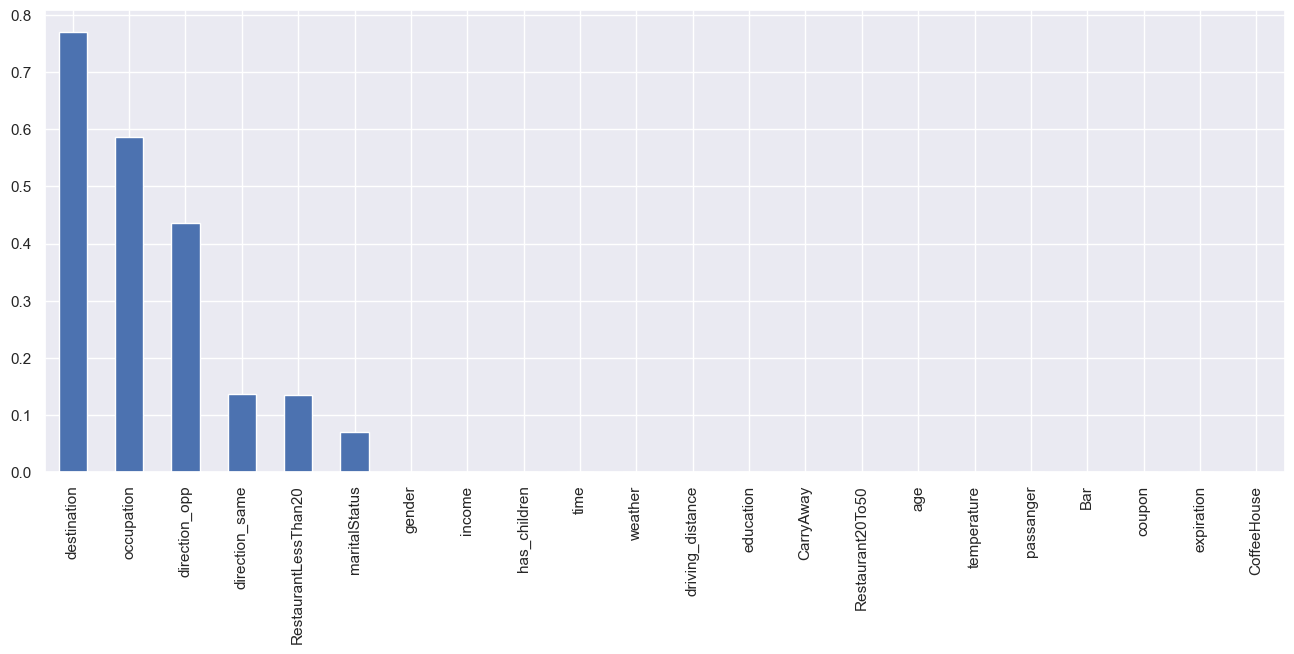

In [39]:
X = df_enco.drop('Y',axis=1)
y = df_enco['Y']
chi_scores = chi2(X,y)
print(chi_scores)
p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(ascending = False , inplace = True)
plt.figure(figsize=(16,6))
p_values.plot.bar()

# Feature Selection

(array([8.51872185e-02, 4.49153726e+01, 2.80958257e+01, 4.15522212e+01,
       2.79059310e+01, 1.09915816e+02, 1.16527040e+02, 1.23766588e+01,
       4.06618193e+01, 3.27933140e+00, 1.49879269e+01, 3.22563112e+01,
       2.95063861e-01, 1.39837347e+01, 6.71770851e+01, 2.97944201e+02,
       3.40513002e+01, 2.24323428e+00, 3.98201425e+01, 2.20550210e+00,
       6.06000274e-01, 2.85147148e+01]), array([7.70387172e-01, 2.05736369e-11, 1.15454615e-07, 1.14764019e-10,
       1.27358779e-07, 1.02241869e-25, 3.64377189e-27, 4.34734409e-04,
       1.80989197e-10, 7.01575045e-02, 1.08201215e-04, 1.35117495e-08,
       5.86993614e-01, 1.84398961e-04, 2.48182102e-16, 9.23986896e-67,
       5.36780295e-09, 1.34200019e-01, 2.78458532e-10, 1.37519112e-01,
       4.36297765e-01, 9.29890840e-08]))


<Axes: >

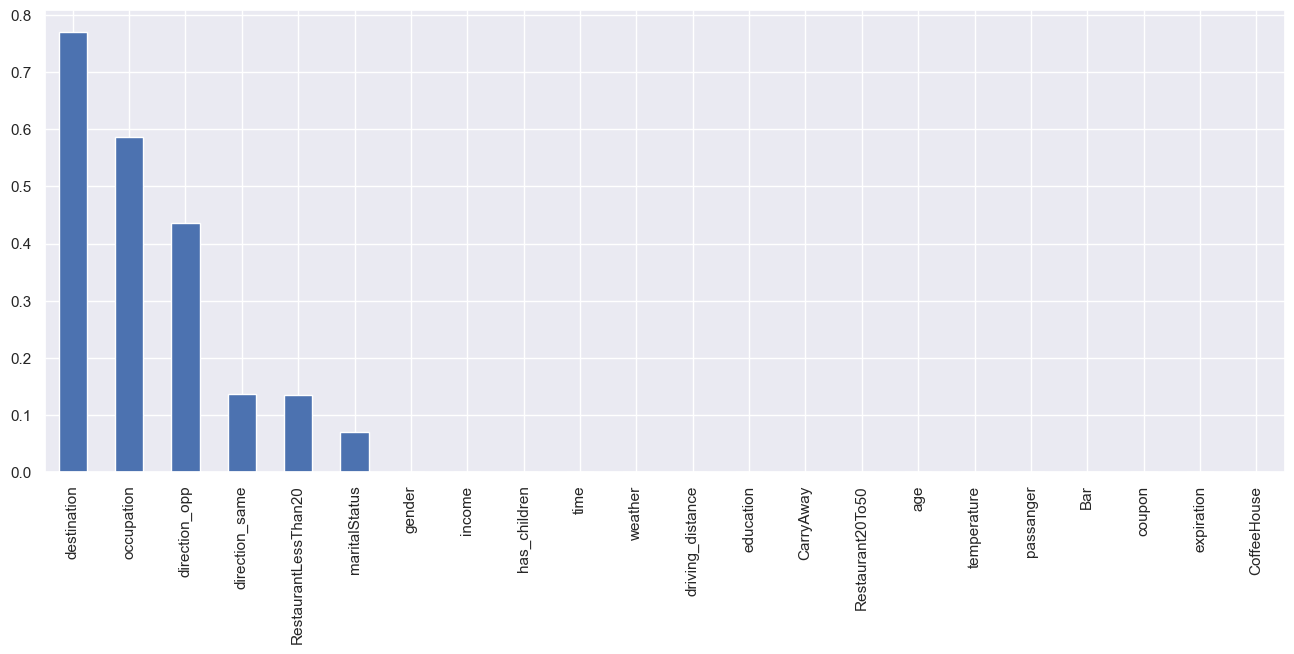

In [40]:
X = df_enco.drop('Y',axis=1)
y = df_enco['Y']
chi_scores = chi2(X,y)
print(chi_scores)
p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(ascending = False , inplace = True)
plt.figure(figsize=(16,6))
p_values.plot.bar()

In [41]:
#Drop column Destination and direction_opp
df = df.drop(columns=['destination'])
df = df.drop(columns=['direction_opp'])


In [42]:
df_enco = df_enco.drop(columns=['destination'])
df_enco=df_enco.drop(columns=['direction_opp'])

# Handling Unbalance Data

In [43]:
#Handling unlance data using SMOTE technique
sm = SMOTE(random_state=42)


# Predictive Modeling
- Naive Bayes
- Decision Tree
- Neural Network
- Logistic Regression

In [44]:
df_NB = df.copy()
X_NB=df_NB.drop('Y',axis=1)
y_NB=df_NB['Y']

In [45]:
def accuracy_score(y_true, y_pred):

	"""	score = (y_true - y_pred) / len(y_true) """

	return round(float(sum(y_pred == y_true))/float(len(y_true)) * 100 ,2)



class  NaiveBayes:

	"""
		Bayes Theorem:
										Likelihood * Class prior probability
				Posterior Probability = -------------------------------------
											Predictor prior probability

							  			 P(x|c) * p(c)
							   P(c|x) = ------------------
											  P(x)
	"""

	def __init__(self):

		"""
			Attributes:
				likelihoods: Likelihood of each feature per class
				class_priors: Prior probabilities of classes
				pred_priors: Prior probabilities of features
				features: All features of dataset
		"""
		self.features = list
		self.likelihoods = {}
		self.class_priors = {}
		self.pred_priors = {}

		self.X_train = np.array
		self.y_train = np.array
		self.train_size = int
		self.num_feats = int

	def fit(self, X, y):

		self.features = list(X.columns)
		self.X_train = X
		self.y_train = y
		self.train_size = X.shape[0]
		self.num_feats = X.shape[1]

		for feature in self.features:
			self.likelihoods[feature] = {}
			self.pred_priors[feature] = {}

			for feat_val in np.unique(self.X_train[feature]):
				self.pred_priors[feature].update({feat_val: 0})

				for outcome in np.unique(self.y_train):
					self.likelihoods[feature].update({feat_val+'_'+outcome:0})
					self.class_priors.update({outcome: 0})


		self._calc_class_prior()
		self._calc_likelihoods()
		self._calc_predictor_prior()

		# print(self.likelihoods)
		# print(self.class_priors)
		# print(self.pred_priors)

	def _calc_class_prior(self):

		""" P(c) - Prior Class Probability """

		for outcome in np.unique(self.y_train):
			outcome_count = sum(self.y_train == outcome)
			self.class_priors[outcome] = outcome_count / self.train_size

	def _calc_likelihoods(self):

		""" P(x|c) - Likelihood """

		for feature in self.features:

			for outcome in np.unique(self.y_train):
				outcome_count = sum(self.y_train == outcome)
				feat_likelihood = self.X_train[feature][self.y_train[self.y_train == outcome].index.values.tolist()].value_counts().to_dict()

				for feat_val, count in feat_likelihood.items():
					self.likelihoods[feature][feat_val + '_' + outcome] = count/outcome_count


	def _calc_predictor_prior(self):

		""" P(x) - Evidence """

		for feature in self.features:
			feat_vals = self.X_train[feature].value_counts().to_dict()

			for feat_val, count in feat_vals.items():
				self.pred_priors[feature][feat_val] = count/self.train_size


	def predict(self, X):

		""" Calculates Posterior probability P(c|x) """

		results = []
		X = np.array(X)

		for query in X:
			probs_outcome = {}
			for outcome in np.unique(self.y_train):
				prior = self.class_priors[outcome]
				likelihood = 1
				evidence = 1

				for feat, feat_val in zip(self.features, query):
					likelihood *= self.likelihoods[feat][feat_val + '_' + outcome]
					evidence *= self.pred_priors[feat][feat_val]

				posterior = (likelihood * prior) / (evidence)

				probs_outcome[outcome] = posterior

			result = max(probs_outcome, key = lambda x: probs_outcome[x])
			results.append(result)

		return np.array(results)


In [46]:
X_NB_train, X_NB_test, y_NB_train, y_NB_test = train_test_split(X_NB , y_NB,
                                                                shuffle = True,
                                                                test_size=0.25,
                                                                random_state=1)

print('X_train:', X_NB_train.shape)
print('X_test:', X_NB_test.shape)

X_train: (9457, 20)
X_test: (3153, 20)


In [47]:
nb_clf = NaiveBayes()
nb_clf.fit(X_NB_train, y_NB_train)

In [48]:
print("Train Accuracy: {}".format(accuracy_score(y_NB_train, nb_clf.predict(X_NB_train))))
print("Test Accuracy: {}".format(accuracy_score(y_NB_test, nb_clf.predict(X_NB_test))))

Train Accuracy: 66.98
Test Accuracy: 66.57


In [49]:
y_NB_pred=nb_clf.predict(X_NB_test)
confusion = confusion_matrix(y_NB_test, y_NB_pred)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[1355  447]
 [ 607  744]]


In [50]:
print('\nAccuracy: {:.2f}'.format(accuracy_score(y_NB_test, y_NB_pred)))
print('Precision : {:.2f}'.format(precision_score(y_NB_test, y_NB_pred, pos_label='Accept', average='binary')))
print('Recal : {:.2f}'.format(recall_score(y_NB_test, y_NB_pred, pos_label='Accept', average='binary')))
print('F1 Score : {:.2f}'.format(f1_score(y_NB_test, y_NB_pred, pos_label='Accept', average='binary')))


Accuracy: 66.57
Precision : 0.69
Recal : 0.75
F1 Score : 0.72


In [51]:
print('\nNaive Bayes Classification Report\n')
print(classification_report(y_NB_test, y_NB_pred))


Naive Bayes Classification Report

              precision    recall  f1-score   support

      Accept       0.69      0.75      0.72      1802
      Reject       0.62      0.55      0.59      1351

    accuracy                           0.67      3153
   macro avg       0.66      0.65      0.65      3153
weighted avg       0.66      0.67      0.66      3153



# Naive Bayes with Handling Unbalanced Data
Below before perform naive bayes classifier modeling, we handle the unbalance data using SMOTE

In [52]:
df_NB_smt = df_enco.copy()
X_NB_smt=df_NB_smt.drop('Y',axis=1)
y_NB_smt=df_NB_smt['Y']

In [53]:
XNB_train, XNB_test, yNB_train, yNB_test = train_test_split(X_NB_smt , y_NB_smt,
                                                                shuffle = True,
                                                                test_size=0.25,
                                                                random_state=1)

print('X_train:', XNB_train.shape)
print('X_test:', XNB_test.shape)

X_train: (9457, 20)
X_test: (3153, 20)


In [54]:
# Handle the unbalnce data using SMOTE technique
X_NB_train_smte, y_NB_train_smte = sm.fit_resample(XNB_train, yNB_train)

In [55]:
print("Before OverSampling, counts of label '1': {}".format(sum(yNB_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(yNB_train == 0)))
print('After OverSampling, the shape of train_X: {}'.format(X_NB_train_smte.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_NB_train_smte.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_NB_train_smte == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_NB_train_smte == 0)))


Before OverSampling, counts of label '1': 4102
Before OverSampling, counts of label '0': 5355 

After OverSampling, the shape of train_X: (10710, 20)
After OverSampling, the shape of train_y: (10710,) 

After OverSampling, counts of label '1': 5355
After OverSampling, counts of label '0': 5355


In [56]:
from sklearn.naive_bayes import CategoricalNB
clf=CategoricalNB()

In [57]:
clf.fit(X_NB_train_smte, y_NB_train_smte)

CategoricalNB()

In [58]:
print("Train Accuracy: {}".format(accuracy_score(y_NB_train_smte, clf.predict(X_NB_train_smte))))
print("Test Accuracy: {}".format(accuracy_score(yNB_test, clf.predict(XNB_test))))

Train Accuracy: 66.58
Test Accuracy: 66.0


In [59]:
y_NB_pred_smt=clf.predict(XNB_test)
confusion = confusion_matrix(yNB_test, y_NB_pred_smt)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[1240  562]
 [ 510  841]]


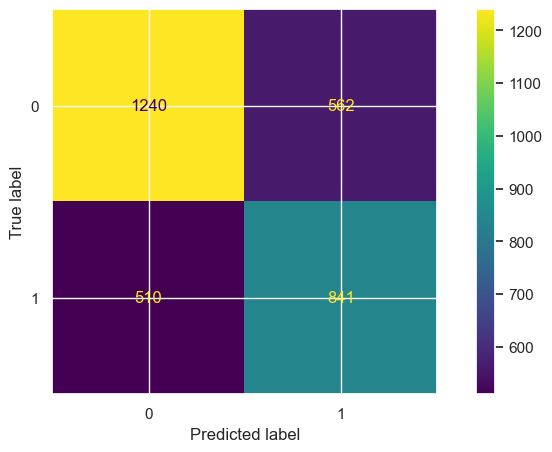

In [60]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion = confusion_matrix(yNB_test, y_NB_pred_smt,labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion,display_labels=clf.classes_)
disp.plot()
plt.show()

In [61]:
print('\nAccuracy: {:.2f}'.format(accuracy_score(yNB_test, y_NB_pred_smt)))
print('Precision : {:.2f}'.format(precision_score(yNB_test, y_NB_pred_smt, pos_label=1, average='binary')))
print('Recal : {:.2f}'.format(recall_score(yNB_test, y_NB_pred_smt, pos_label=1, average='binary')))
print('F1 Score : {:.2f}'.format(f1_score(yNB_test, y_NB_pred_smt, pos_label=1, average='binary')))


Accuracy: 66.00
Precision : 0.60
Recal : 0.62
F1 Score : 0.61


In [62]:
print('\nNaive Bayes Classification Report\n')
print(classification_report(yNB_test, y_NB_pred_smt))


Naive Bayes Classification Report

              precision    recall  f1-score   support

           0       0.71      0.69      0.70      1802
           1       0.60      0.62      0.61      1351

    accuracy                           0.66      3153
   macro avg       0.65      0.66      0.65      3153
weighted avg       0.66      0.66      0.66      3153



# Decision Tree

In [63]:
df_DT = df_enco.copy()

In [64]:
X_DT = df_DT.drop('Y',axis=1)
y_DT = df_DT['Y']

In [65]:
eps = np.finfo(float).eps

def accuracy_score(y_true, y_pred):

	"""	score = (y_true - y_pred) / len(y_true) """

	return round(float(sum(y_pred == y_true))/float(len(y_true)) * 100 ,2)


class DecisionTreeClassifier:

	def __init__(self, max_depth = None, min_sample_leaf = None):

		self.depth = 0 #Depth of the tree
		self.max_depth = max_depth	#Maximum depth of the tree
		self.min_sample_leaf = min_sample_leaf	#Minimum number of samples for each node

		self.features = list
		self.X_train = np.array
		self.y_train = np.array
		self.num_feats = int
		self.train_size = int

	def fit(self, X, y):

		self.X_train = X
		self.y_train = y
		self.features = list(X.columns)
		self.train_size = X.shape[0]
		self.num_feats = X.shape[1]

		df = X.copy()
		df['target'] = y.copy()

		#Builds Decision Tree
		self.tree = self._build_tree(df)

		print("\nDecision Tree(depth = {}) : \n {}".format(self.depth, self.tree))

	def _build_tree(self, df, tree = None):

		"""
			Args:
				df: current number of rows available for splitting(decision making)
		"""

		#Get feature with maximum information gain
		feature, cutoff = self._find_best_split(df)

		#Initialization of tree
		if tree is None:
			tree = {}
			tree[feature] = {}

		if df[feature].dtypes == object:
			"""
				- to handle columns with Categorical Values(object type)
 				- parent have only one child
			"""
			for feat_val in np.unique(df[feature]):

				new_df = self._split_rows(df, feature, feat_val, operator.eq)
				targets, count = np.unique(new_df['target'], return_counts = True)

				if(len(count) == 1): #pure group
					tree[feature][feat_val] = targets[0]
				else:
					self.depth += 1
					if self.max_depth is not None and self.depth >= self.max_depth:
						tree[feature][feat_val] = targets[np.argmax(count)]
					else:
						tree[feature][feat_val] = self._build_tree(new_df)

		else:
			"""
				- to handle columns with Numerical Values(int, float....)
 				- parent have two child
 				- Left Child: rows with <= cutoff
 				- Right Child:  rows with > cutoff
			"""
			#Left Child
			new_df = self._split_rows(df, feature, cutoff, operator.le)
			targets, count = np.unique(new_df['target'], return_counts = True)

			self.depth += 1

			if(len(count) == 1): #pure group
				tree[feature]['<=' + str(cutoff)] = targets[0]
			else:
				if self.max_depth is not None and self.depth >= self.max_depth:
					tree[feature]['<=' + str(cutoff)] = targets[np.argmax(count)]
				else:
					tree[feature]['<=' + str(cutoff)] = self._build_tree(new_df)


			#Right Child
			new_df = self._split_rows(df, feature, cutoff, operator.gt)
			targets, count = np.unique(new_df['target'], return_counts = True)

			if(len(count) == 1): #pure group
				tree[feature]['>' + str(cutoff)] = targets[0]
			else:
				if self.max_depth is not None and self.depth >= self.max_depth:
					tree[feature]['>' + str(cutoff)] = targets[np.argmax(count)]
				else:
					tree[feature]['>' + str(cutoff)] = self._build_tree(new_df)

		return tree


	def _split_rows(self, df, feature, feat_val, operation ):

		""" split rows based on given criterion """

		return df[operation(df[feature], feat_val)].reset_index(drop = True)

	def _find_best_split(self, df):

		"""
			Finds the column to split on first using 'Information Gain' Metric.
			Information Gain(IG) = Entropy(parent) - Sum of Entropy(Children)
						IG(T, a) = H(T) - H(T|a)
			Entropy(parent) H(T) = (Sum[i=1 to J](- Pi * log(Pi)))
			Sum of Entropy(children) H(T|a) = Sum(P(a) * Sum[i=1 to J](- P(i|a) * log(P(i|a)))
			Returns:
				Feature With Maximum Information Gain
		"""

		ig = []
		thresholds = []

		for feature in list(df.columns[:-1]):

			entropy_parent = self._get_entropy(df) #H(T)
			entropy_feature_split, threshold = self._get_entropy_feature(df, feature) #H(T|a)

			info_gain = entropy_parent - entropy_feature_split #IG(T, a)

			ig.append(info_gain)
			thresholds.append(threshold)


		return df.columns[:-1][np.argmax(ig)], thresholds[np.argmax(ig)] #Returns feature with max information gain

	def _get_entropy(self, df):

		""" Finds Entropy of parent ie., H(T) """

		entropy = 0
		for target in np.unique(df['target']):
			fraction = df['target'].value_counts()[target] / len(df['target'])
			entropy += -fraction * np.log2(fraction)

		return entropy

	def _get_entropy_feature(self, df, feature):

		""" Finds Sum of entropy of children ie., H(T|a) """

		entropy = 0
		threshold = None

		if(df[feature].dtypes == object):

			#sum of entropies of children(all distinct features)
			for feat_val in np.unique(df[feature]):
				entropy_feature = 0

				#entropy for each distinct feature value
				for target in np.unique(df['target']):
					num = len(df[feature][df[feature] == feat_val][df['target'] == target])
					den = len(df[feature][df[feature] == feat_val])

					fraction = num / (den+eps)
					entropy_feature += -fraction * np.log2(fraction + eps)

				weightage = den/len(df)
				entropy += weightage * entropy_feature
		else:
			entropy = 1 #Max Value

			prev = 0
			for feat_val in np.unique(df[feature]):
				cur_entropy = 0
				cutoff = (feat_val + prev)/2

				#sum of entropies of left child(<= cutoff) and right child(> cutoff)
				for operation in [operator.le, operator.gt]:
					entropy_feature = 0

					for target in np.unique(df['target']):
						num = len(df[feature][operation(df[feature], cutoff)][df['target'] == target])
						den = len(df[feature][operation(df[feature], cutoff)])

						fraction = num / (den + eps)
						entropy_feature += -fraction * np.log2(fraction + eps)

					weightage = den/len(df)
					cur_entropy += weightage * entropy_feature

				if cur_entropy < entropy:
					entropy = cur_entropy
					threshold = cutoff
				prev = feat_val

		return entropy, threshold

	def _predict_target(self, feature_lookup, x, tree):

		for node in tree.keys():
			val = x[node]
			if type(val) == str:
				tree = tree[node][val]
			else:
				cutoff = str(list(tree[node].keys())[0]).split('<=')[1]

				if(val <= float(cutoff)):	#Left Child
					tree = tree[node]['<='+cutoff]
				else:						#Right Child
					tree = tree[node]['>'+cutoff]

			prediction = str

			if type(tree) is dict:
				prediction = self._predict_target(feature_lookup, x, tree)
			else:
				predicton = tree
				return predicton

		return prediction


	def predict(self, X):

		results = []
		feature_lookup = {key: i for i, key in enumerate(list(X.columns))}

		for index in range(len(X)):

			results.append(self._predict_target(feature_lookup, X.iloc[index], self.tree))

		return np.array(results)

In [66]:
# 12610 learning curve: 0.9 training size = 1261, 0.8 r=2522, 0.7 r=3783, 0.6 r=5044, 0.5 r=6305, 0.4r=7566 ,0.3 r=8827, 0.2 r=10088

X_DT_train, X_DT_test, y_DT_train, y_DT_test = train_test_split(X_DT, y_DT, test_size = 0.25, random_state = 0)
print('X_train:', X_DT_train.shape)
print('X_test:', X_DT_test.shape)

X_train: (9457, 20)
X_test: (3153, 20)


In [67]:
# Handle the unbalnce data using SMOTE technique
X_DT_train, y_DT_train = sm.fit_resample(X_DT_train, y_DT_train)

In [68]:
dt = DecisionTreeClassifier(max_depth = 90)
dt.fit(X_DT_train, y_DT_train)


Decision Tree(depth = 90) : 
 {'coupon': {'<=3.5': {'CoffeeHouse': {'<=2.5': {'weather': {'<=1.5': {'temperature': {'<=0.0': 1, '>0.0': {'coupon': {'<=0.0': {'Bar': {'<=1.5': {'occupation': {'<=5.5': {'maritalStatus': {'<=2.5': {'education': {'<=0.0': {'time': {'<=1.5': 1, '>1.5': {'gender': {'<=0.0': 0, '>0.0': 1}}}}, '>0.0': {'temperature': {'<=1.5': {'Restaurant20To50': {'<=2.0': {'occupation': {'<=1.5': 0, '>1.5': {'occupation': {'<=3.0': {'has_children': {'<=0.0': 1, '>0.0': 0}}, '>3.0': 0}}}}, '>2.0': {'income': {'<=1.5': {'income': {'<=0.0': {'age': {'<=0.0': 1, '>0.0': 0}}, '>0.0': 0}}, '>1.5': 1}}}}, '>1.5': {'income': {'<=2.5': {'age': {'<=0.0': {'has_children': {'<=0.0': {'time': {'<=3.5': {'time': {'<=0.0': 1, '>0.0': 0}}, '>3.5': 1}}, '>0.0': {'expiration': {'<=0.0': {'occupation': {'<=0.0': {'time': {'<=3.5': 0, '>3.5': 1}}, '>0.0': 0}}, '>0.0': 1}}}}, '>0.0': 1}}, '>2.5': {'time': {'<=2.0': 0, '>2.0': {'CoffeeHouse': {'<=1.5': {'CoffeeHouse': {'<=0.0': {'passanger': {'<

In [69]:
print("Train Accuracy: {}".format(accuracy_score(y_DT_train, dt.predict(X_DT_train))))
print("Test Accuracy: {}".format(accuracy_score(y_DT_test, dt.predict(X_DT_test))))

Train Accuracy: 63.48
Test Accuracy: 61.47


In [70]:
y_DT_pred=dt.predict(X_DT_test)

confusion = confusion_matrix(y_DT_test, y_DT_pred)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[1173  669]
 [ 546  765]]


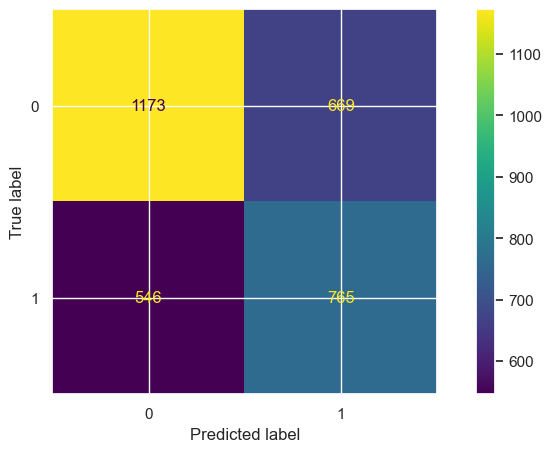

In [71]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion = confusion_matrix(y_DT_test, y_DT_pred,labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion,display_labels=clf.classes_)
disp.plot()
plt.show()

In [72]:
print('\nAccuracy: {:.3f}'.format(accuracy_score(y_DT_test, y_DT_pred)))
print('Precision : {:.3f}'.format(precision_score(y_DT_test, y_DT_pred, pos_label=1, average='binary')))
print('Recal : {:.3f}'.format(recall_score(y_DT_test, y_DT_pred, pos_label=1, average='binary')))
print('F1 Score : {:.3f}'.format(f1_score(y_DT_test, y_DT_pred, pos_label=1, average='binary')))


Accuracy: 61.470
Precision : 0.533
Recal : 0.584
F1 Score : 0.557


In [73]:

print('\nDecision Tree Classification Report\n')
print(classification_report(y_DT_test, y_DT_pred))


Decision Tree Classification Report

              precision    recall  f1-score   support

           0       0.68      0.64      0.66      1842
           1       0.53      0.58      0.56      1311

    accuracy                           0.61      3153
   macro avg       0.61      0.61      0.61      3153
weighted avg       0.62      0.61      0.62      3153



# Neural Network

In [74]:
df_nn = df_enco.copy()

In [75]:
X_NN = df_nn.drop('Y',axis=1)
y_NN = df_nn['Y']

In [76]:
X_NN_train, X_NN_test, y_NN_train, y_NN_test = train_test_split(X_NN, y_NN, test_size=0.1, random_state= 0)

In [77]:
# Handle the unbalnce data using SMOTE technique
X_NN_train, y_NN_train = sm.fit_resample(X_NN_train, y_NN_train)

In [78]:
from keras.models import load_model

Epoch 1/200
391/402 [============================>.] - ETA: 0s - loss: 0.7109 - accuracy: 0.5451
Epoch 1: val_accuracy improved from -inf to 0.62331, saving model to C:\Users\Roswita Hede\Documents\IE7300\final project\best_model.h5
402/402 [==============================] - 5s 6ms/step - loss: 0.7097 - accuracy: 0.5456 - val_loss: 0.6618 - val_accuracy: 0.6233
Epoch 2/200
 11/402 [..............................] - ETA: 2s - loss: 0.6715 - accuracy: 0.5739

C:\Users\Roswita Hede\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


394/402 [============================>.] - ETA: 0s - loss: 0.6795 - accuracy: 0.5687
Epoch 2: val_accuracy improved from 0.62331 to 0.63204, saving model to C:\Users\Roswita Hede\Documents\IE7300\final project\best_model.h5
402/402 [==============================] - 2s 5ms/step - loss: 0.6789 - accuracy: 0.5705 - val_loss: 0.6577 - val_accuracy: 0.6320
Epoch 3/200
392/402 [============================>.] - ETA: 0s - loss: 0.6670 - accuracy: 0.5885
Epoch 3: val_accuracy did not improve from 0.63204
402/402 [==============================] - 2s 5ms/step - loss: 0.6672 - accuracy: 0.5881 - val_loss: 0.6539 - val_accuracy: 0.6201
Epoch 4/200
392/402 [============================>.] - ETA: 0s - loss: 0.6585 - accuracy: 0.6157
Epoch 4: val_accuracy improved from 0.63204 to 0.63600, saving model to C:\Users\Roswita Hede\Documents\IE7300\final project\best_model.h5
402/402 [==============================] - 2s 5ms/step - loss: 0.6588 - accuracy: 0.6153 - val_loss: 0.6431 - val_accuracy: 0.6360

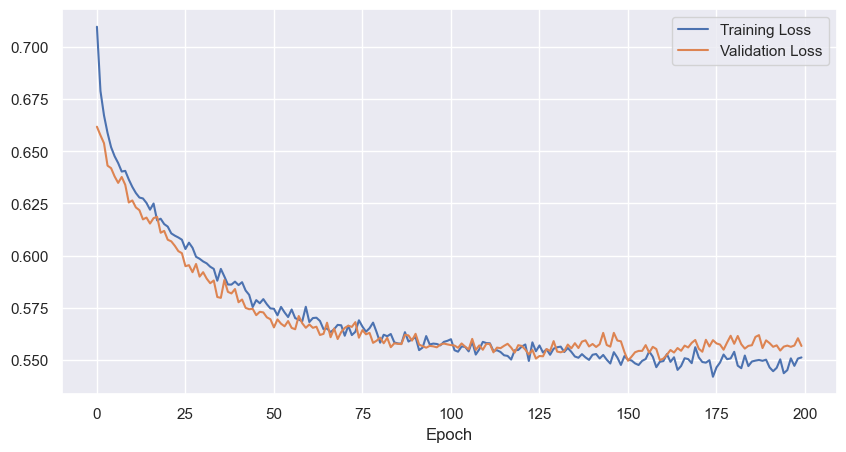

In [79]:
# Create a neural network model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler
input_layer = Input(shape=(X_NN_train.shape[1],))
x = Dense(64, activation='relu')(input_layer)
x = Dropout(0.5)(x)
x = Dense(37, activation='relu')(x)
x = Dropout(0.5)(x) 
output_layer = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

sc = StandardScaler()
# Preprocess the training data
X_NN_train = sc.fit_transform(X_NN_train)
X_NN_test = sc.transform(X_NN_test)

#Define early stopping callback
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = ModelCheckpoint(r'C:\Users\Roswita Hede\Documents\IE7300\final project\best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Create lists to store training history
history = model.fit(X_NN_train, y_NN_train,validation_data=(X_NN_test, y_NN_test), epochs=200, batch_size=32, verbose=1, callbacks=[es,mc])

# Load the best model from the checkpoint
best_model = tf.keras.models.load_model('best_model.h5') 

# Evaluate the model
loss, accuracy = model.evaluate(X_NN_test, y_NN_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')


print(f'Best model accuracy for train data: {loss}, Best model accuracy for test data: {accuracy}')
# Plot training and validation accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [80]:
X_NN_train_fix, X_NN_test_fix, y_NN_train_fix, y_NN_test_fix = train_test_split(X_NN, y_NN, test_size=0.1, random_state= 0)

In [81]:
# Handle the unbalnce data using SMOTE technique
X_NN_train_fix, y_NN_train_fix = sm.fit_resample(X_NN_train_fix, y_NN_train_fix)

In [82]:
# Preprocess the training data
X_NN_train_fix = sc.fit_transform(X_NN_train_fix)
X_NN_test_fix = sc.transform(X_NN_test_fix)

In [83]:
#Based on calculation above, the best epoch is 147.
# neural network with epoch=147
#Initialising ANN
ann = tf.keras.models.Sequential()
#Adding First Hidden Layer
ann.add(tf.keras.layers.Dense(units=64,activation="relu"))
#Adding Second Hidden Layer
ann.add(tf.keras.layers.Dense(units=37,activation="relu"))
ann.add(tf.keras.layers.Dropout(rate=0.5))
#Adding Output Layer
ann.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))
# Compile the model
ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
ann.fit(X_NN_train_fix,y_NN_train_fix,batch_size=32,epochs = 127, validation_split=0.2)

Epoch 1/127
322/322 [==============================] - 4s 6ms/step - loss: 0.6765 - accuracy: 0.5856 - val_loss: 0.7129 - val_accuracy: 0.5117
Epoch 2/127
322/322 [==============================] - 2s 5ms/step - loss: 0.6444 - accuracy: 0.6257 - val_loss: 0.7077 - val_accuracy: 0.5280
Epoch 3/127
322/322 [==============================] - 2s 5ms/step - loss: 0.6361 - accuracy: 0.6362 - val_loss: 0.7070 - val_accuracy: 0.5334
Epoch 4/127
322/322 [==============================] - 2s 5ms/step - loss: 0.6276 - accuracy: 0.6461 - val_loss: 0.6876 - val_accuracy: 0.5622
Epoch 5/127
322/322 [==============================] - 2s 5ms/step - loss: 0.6224 - accuracy: 0.6536 - val_loss: 0.6728 - val_accuracy: 0.5778
Epoch 6/127
322/322 [==============================] - 2s 5ms/step - loss: 0.6179 - accuracy: 0.6559 - val_loss: 0.6815 - val_accuracy: 0.5813
Epoch 7/127
322/322 [==============================] - 2s 5ms/step - loss: 0.6128 - accuracy: 0.6579 - val_loss: 0.6883 - val_accuracy: 0.5700

In [84]:
#Fitting ANN
train_acc=ann.fit(X_NN_train_fix,y_NN_train_fix,batch_size=32,epochs = 127, validation_split=0.2)


Epoch 1/127
322/322 [==============================] - 2s 5ms/step - loss: 0.4227 - accuracy: 0.7851 - val_loss: 0.6159 - val_accuracy: 0.7197
Epoch 2/127
322/322 [==============================] - 2s 5ms/step - loss: 0.4281 - accuracy: 0.7830 - val_loss: 0.6084 - val_accuracy: 0.7201
Epoch 3/127
322/322 [==============================] - 2s 5ms/step - loss: 0.4236 - accuracy: 0.7786 - val_loss: 0.6106 - val_accuracy: 0.7220
Epoch 4/127
322/322 [==============================] - 2s 5ms/step - loss: 0.4218 - accuracy: 0.7831 - val_loss: 0.5985 - val_accuracy: 0.7317
Epoch 5/127
322/322 [==============================] - 2s 5ms/step - loss: 0.4224 - accuracy: 0.7808 - val_loss: 0.6229 - val_accuracy: 0.7154
Epoch 6/127
322/322 [==============================] - 2s 5ms/step - loss: 0.4235 - accuracy: 0.7847 - val_loss: 0.5871 - val_accuracy: 0.7344
Epoch 7/127
322/322 [==============================] - 2s 5ms/step - loss: 0.4238 - accuracy: 0.7853 - val_loss: 0.5964 - val_accuracy: 0.7232

In [85]:
# Evaluate the model
loss, accuracy=ann.evaluate(X_NN_test_fix, y_NN_test_fix)

print(f'loss: {loss}, Test Accuracy: {accuracy}')

40/40 [==============================] - 0s 3ms/step - loss: 0.7189 - accuracy: 0.7082
loss: 0.7188554406166077, Test Accuracy: 0.7081681489944458


In [86]:
# predict probabilities for test set
yhat_probs = ann.predict(X_NN_test_fix, verbose=0)
# predict crisp classes for test set
y_pred = ann.predict(X_NN_test_fix, verbose=0)

In [87]:
# Make predictions on the test data
y_pred = ann.predict(X_NN_test)

# Threshold the probabilities to get binary predictions (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate the classification report
target_names = ["Class 0", "Class 1"]  # Adjust class labels as needed
print(classification_report(y_NN_test, y_pred_binary, target_names=target_names))

40/40 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

     Class 0       0.75      0.75      0.75       729
     Class 1       0.65      0.66      0.65       532

    accuracy                           0.71      1261
   macro avg       0.70      0.70      0.70      1261
weighted avg       0.71      0.71      0.71      1261



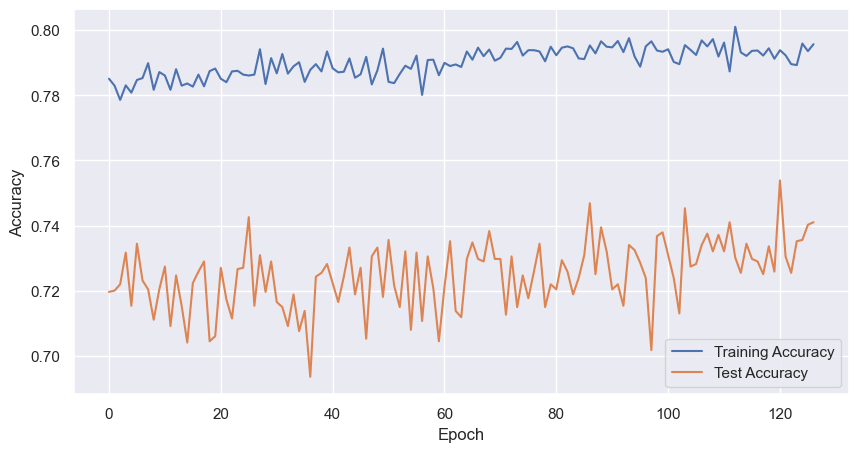

In [88]:
# Plot training and validation accuracy
plt.plot(train_acc.history['accuracy'],label='Training Accuracy')
plt.plot(train_acc.history['val_accuracy'],label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Logistic Regression

In [89]:
df_LR = df_enco.copy()

In [90]:
X_lr = df_LR.drop('Y',axis=1)
y_lr = df_LR['Y']

test_X = X.sample(frac = 0.85, random_state = None)
test_y = y[test_X.index]
train_X = X.drop(test_X.index)
train_y = y.drop(test_y.index)


In [91]:
#split data
train_X, test_X, train_y, test_y = train_test_split(X_lr, y_lr, test_size=0.25, random_state= 0)
print('train_X:', train_X.shape)
print('test_X:', test_X.shape)

train_X: (9457, 20)
test_X: (3153, 20)


In [92]:
train_X, train_y = sm.fit_resample(train_X, train_y)

In [93]:
lr= LogisticRegression()
lr.fit(train_X, train_y)

LogisticRegression()

In [94]:
y_pred = lr.predict(test_X)

In [95]:
print("train accuracy: {}".format(accuracy_score(train_y, lr.predict(train_X))))
print("test accuracy: {}".format(accuracy_score(test_y, lr.predict(test_X))))

train accuracy: 62.65
test accuracy: 61.31


In [101]:
from sklearn.metrics import classification_report
print('\nLogistic Regression Classification Report\n')
print(classification_report(test_y, y_pred))


Logistic Regression Classification Report

              precision    recall  f1-score   support

           0       0.69      0.62      0.65      1842
           1       0.53      0.62      0.57      1311

    accuracy                           0.62      3153
   macro avg       0.61      0.62      0.61      3153
weighted avg       0.63      0.62      0.62      3153



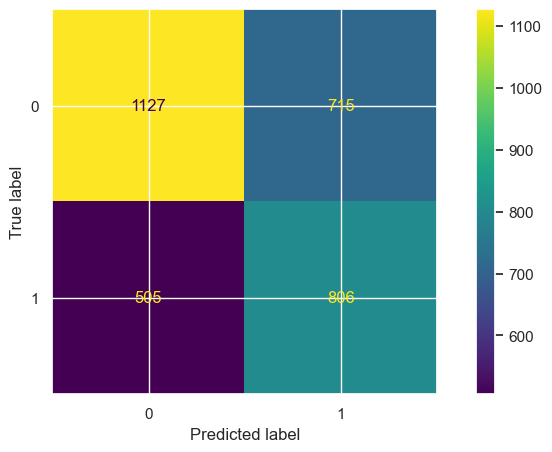

In [97]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion = confusion_matrix(test_y, y_pred,labels=lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion,display_labels=lr.classes_)
disp.plot()
plt.show()

# Model Hyperparameter Tunning

In [98]:
# Tunning Hyperparamter for Naive Bayes

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import PowerTransformer
from sklearn.naive_bayes import GaussianNB

cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=999)
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

gs_NB = GridSearchCV(estimator=GaussianNB(), 
                     param_grid=params_NB, 
                     cv=cv_method, 
                     scoring='accuracy')

gs_NB.fit(X_NB_train_smte, y_NB_train_smte)
# Print the best hyperparameters found
print("Best hyperparameters found:")
print(gs_NB.best_params_)

# Get the best estimator (classifier)
best_nb_classifier = gs_NB.best_estimator_

# Evaluate the best model on the test set
y_pred = best_nb_classifier.predict(XNB_test)
test_accuracy = accuracy_score(yNB_test, y_pred)
print(f"Test accuracy of the best model: {test_accuracy}")
# Calculate and print the classification report
target_names = [str(i) for i in np.unique(yNB_test)]  # Assuming class labels are numeric
print(classification_report(yNB_test, y_pred, target_names=target_names))

Best hyperparameters found:
{'var_smoothing': 0.008111308307896872}
Test accuracy of the best model: 61.34
              precision    recall  f1-score   support

           0       0.67      0.65      0.66      1802
           1       0.55      0.56      0.56      1351

    accuracy                           0.61      3153
   macro avg       0.61      0.61      0.61      3153
weighted avg       0.61      0.61      0.61      3153



In [99]:
# Tunning Hyperparamter for Decision Tree
params = {
    'max_depth': [ 10, 20, 80, 90, 100],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
# Create a grid search object
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

# Perform the grid search to find the best hyperparameters
grid_search.fit(X_DT_train, y_DT_train)

# Print the best hyperparameters found
print("Best hyperparameters found:")
print(grid_search.best_params_)

# Get the best estimator (classifier)
best_dt_classifier = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_dt_classifier.predict(X_DT_test)
test_accuracy = accuracy_score(y_DT_test, y_pred)
print(f"Test accuracy of the best model: {test_accuracy}")
# Calculate and print the classification report
target_names = [str(i) for i in np.unique(y_DT_test)]  # Assuming class labels are numeric
print(classification_report(y_DT_test, y_pred, target_names=target_names))

Fitting 4 folds for each of 50 candidates, totalling 200 fits
Best hyperparameters found:
{'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 20}
Test accuracy of the best model: 67.78
              precision    recall  f1-score   support

           0       0.72      0.72      0.72      1842
           1       0.61      0.61      0.61      1311

    accuracy                           0.68      3153
   macro avg       0.67      0.67      0.67      3153
weighted avg       0.68      0.68      0.68      3153



In [100]:
# Define hyperparameters for logistic Regression
param_grid = {
    'penalty': ['l1', 'l2'],                # Regularization penalty
    'C': [0.001, 0.01, 0.1, 1.0, 10.0],    # Inverse of regularization strength
    'solver': ['liblinear', 'saga']         # Optimization algorithm
}

# Create a Logistic Regression classifier
logistic_reg = LogisticRegression()

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=logistic_reg, param_grid=param_grid, cv=3, scoring='accuracy')

# Fit the grid search to find the best hyperparameters
grid_search.fit(train_X, train_y)

# Print the best hyperparameters found
print("Best hyperparameters found:")
print(grid_search.best_params_)

# Get the best estimator (Logistic Regression model)
best_logistic_reg = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_logistic_reg.predict(test_X)
test_accuracy = accuracy_score(test_y, y_pred)
print(f"Test accuracy of the best model: {test_accuracy}")
# Calculate and print the classification report
target_names = [str(i) for i in np.unique(test_y)]  # Assuming class labels are numeric
print(classification_report(test_y, y_pred, target_names=target_names))

Best hyperparameters found:
{'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Test accuracy of the best model: 61.72
              precision    recall  f1-score   support

           0       0.69      0.62      0.65      1842
           1       0.53      0.62      0.57      1311

    accuracy                           0.62      3153
   macro avg       0.61      0.62      0.61      3153
weighted avg       0.63      0.62      0.62      3153

